In [1]:
import scipy as sc
from scipy import signal
import os   #used for directory work
import matplotlib.pyplot as plt #used for creating plots
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches #used for plot legends
%matplotlib inline

In [2]:
burn_d = {'01': [21000 ,22289], '02': [14000, 14972], '03': [20000, 20296], '04': [30000, 34979], '05': [15000, 15974], \
          '06': [6000, 6544], '07': [25000, 27822], '08': [18000, 19810], '09': [20000, 25047], '11': [30000,30681],  \
          '12': [60000, 62937], '13': [50000, 55131], '18': [185000, 192322], '19': [45000, 48831], '20': [24000, 25860],\
          '21': [25000, 27822], '22': [27000, 29484], '23': [45000, 48846], '24': [20000, 23015], '25': [25000, 26797], \
          '26': [25000, 26909], '27': [35000, 36916], '28': [27000, 28673], '29': [25000, 28166], '30': [12000, 13954], \
          '31': [30000, 31046], '32': [25000, 26294], '33': [20000, 23293], '34': [40000,43702]}

In [3]:

def text_finder(path):
    txt_files=[]
    all_files = os.listdir(path) #tells what directory the files are in
    for i in all_files: #reading only the .txt files 
        if i[-4:] == ".txt":
            txt_files.append(i)
    txt_files.sort() #alphabetizes them
    
    return txt_files

def file_to_df(path):
    df= pd.read_csv(path,na_values = ['NAN', "00nan", "NaN"], sep=" ")
    #df.fillna(value=np.nan, inplace=True)
    
    return df

def day_color(df, full_timestamp = True):
    dates = ["2018-03-05", "2018-03-06", "2018-03-17", "2018-05-09", "2018-05-10", \
            "2018-05-11", "2018-09-22", "2019-05-20", "2019-05-21", "2019-05-22", \
            "2019-05-29", "2019-05-31"]
    colors = ["navy", "maroon", "darkolivegreen", "darkorange", "plum", "turquoise", \
              "saddlebrown", "y", "goldenrod", "mediumseagreen", "indigo", "magenta"  ]
    
    
    if full_timestamp == True:
        for t in range(len(dates)):
            if df["TIMESTAMP"][0][:10] ==dates[t]:
                return colors[t]
                break
                l
    if full_timestamp == False:
        for t in range(len(dates)):
            if str(pd.Timestamp(df["YYYY"][0],df["MM"][0],df["DD"][0]))[:10] == dates[t]:
                return colors[t]
                break
                
def fire_start(df,n):    
    ### Finding the start of fire
    x_fire, fire_5sig = 9e10, np.nanmean(df["T"][:n])+5*np.std(df["T"][:n]) 
    start = n-9000
    if n-9000< 0:
        start = 0
    #print(5*np.std(df["T"][start:n]))
    for i in range(n, len(df["T"])):
        if df["T"][i] > fire_5sig:
            x_fire = i
            break
    
    return x_fire


In [45]:
#######################################################
def speed_calculation(df):
    horizontal_speed = np.sqrt(df["V"]**2 + df["U"]**2)**2
    return horizontal_speed

#######################################################
def fire_period_split(var_lst, x_fire, period_t = 9000):
    
    t_start, f_end, t_end  =x_fire-period_t, x_fire+period_t, (len(var_lst)-1)
    if t_start < 0:
        t_start = 0
    
    #if t_ - x_fire > 0:
    #    t_start = s_fire - index_time
    #if s_fire + index_time > t_end:
    #    t_end = s_fire + index_time
    
    
    pre_lst = list(var_lst[int(t_start) : int(x_fire)])
    brn_lst = list(var_lst[int(x_fire) : int(x_fire+period_t)])
    pst_lst = list(var_lst[int(x_fire+period_t) : int(x_fire+(period_t*2))])
    var_mean = np.nanmean(pre_lst)
        
    pre_lst -= var_mean
    brn_lst -= var_mean
    pst_lst -= var_mean
    
    return pre_lst, brn_lst, pst_lst

#######################################################
def welch_spectra(var_lst, freq = 10):
    
    nan_count = 0 
    
    df = pd.DataFrame()
    
    df["var"] = var_lst
    #nan_count = int(len(df) - df.count())
    #print(nan_count)
    df = df.interpolate(method='linear', axis=0)
    df.fillna(value=0, inplace=True)
    
    #var_lst = list(df["var"])
    #for i in range(len(var_lst)):
    #    if str(var_lst[i]).lower() =="nan": 

     #       var_lst[i] = 0 
     #       nan_count+= 1
    #count_nan = len(df) - df.count()
    welch_lst, x_lst = signal.welch(list(df["var"]), freq)#, nperseg = 28) #,nperseg=8000, average='median')
    #norm = np.linalg.norm(welch_lst)
    #normal_array = welch_lst/norm
    
    return  welch_lst, x_lst

#def calculations():

In [46]:
print(len(burn_d))


29


In [75]:

def burn_PDS_averages(df_list, sigma_fire, variable, burn):
    sc_name_lst= ["A1","A2", "A3", "A4", "B1", "B2", "B3", "B4", \
                 "C1", "C2", "C3", "C4", "D1", "D2", "D3", "D4"]
    df_pre_y, df_pre_x = pd.DataFrame(), pd.DataFrame()
    df_brn_y, df_brn_x = pd.DataFrame(), pd.DataFrame()
    df_pst_y, df_pst_x = pd.DataFrame(), pd.DataFrame()

    for i in range(16):
        df = df_list[i]
        #if burn == 27:
            #if sc_name_lst[i] in ["B1", "B3", "B4", "C3"]:
            #    continue
        #if burn == 8 and sc_name_lst[i]=="B3":
        #    continue
        
        if sigma_fire == True:
            if variable !="S":
                pre_lst, brn_lst, pst_lst = fire_period_split(list(df[variable]), burn_d[burn][1])
            if variable == "S":
                pre_lst, brn_lst, pst_lst = fire_period_split(speed_calculation(df), burn_d[burn][1])
        
        if sigma_fire == False:
            x_fire = fire_start(df, burn_d[burn][0])
            if x_fire == 9e10:
                continue
                x_fire = burn_d[burn][1]
                temp_5sig = "*"
            if variable !="S":
                pre_lst, brn_lst, pst_lst = fire_period_split(list(df[variable]), x_fire)
            if variable == "S":
                pre_lst, brn_lst, pst_lst = fire_period_split(speed_calculation(df), x_fire)

        
        pre_x, pre_y = welch_spectra(pre_lst)
        brn_x, brn_y = welch_spectra(brn_lst)
        pst_x, pst_y = welch_spectra(pst_lst)

        for val in range(len(pre_x)):
            if pre_y[val]<=10**(-6):
                pre_y[val] = np.nan
        for val in range(len(brn_x)):       
            if brn_y[val]<=10**(-6):
                brn_y[val] = np.nan
        for val in range(len(pst_x)):
            if pst_y[val]<=10**(-6):
                pst_y[val] = np.nan
        if len(pre_x) == 129:
            df_pre_x[sc_name_lst[i]+"_x"] = pre_x 
            df_pre_y[sc_name_lst[i]+"_y"] = pre_y
        if len(brn_x) == 129:
            df_brn_x[sc_name_lst[i]+"_x"] = brn_x 
            df_brn_y[sc_name_lst[i]+"_y"] = brn_y
        if len(pst_x) == 129: 
            df_pst_x[sc_name_lst[i]+"_x"] = pst_x 
            df_pst_y[sc_name_lst[i]+"_y"] = pst_y

       
    sig = 1
    df_stats = pd.DataFrame()
    #### Pre Burn stats
    df_stats["pre_x"] = df_pre_x.mean(axis = 1)
    df_stats['pre_avg_y'] = df_pre_y.mean(axis = 1)
    df_stats['pre_min_y'] = df_pre_y.min(axis = 1)
    df_stats['pre_max_y'] = df_pre_y.max(axis = 1)
    
    df_stats['pre_-sig_y'] = ((df_pre_y.std(axis = 1)*-1*sig)+df_pre_y.mean(axis = 1))
    df_stats["pre_+sig_y"] = ((df_pre_y.std(axis = 1)*sig)+df_pre_y.mean(axis = 1))
    
    #### Burn Stats
    df_stats["brn_x"] = df_brn_x.mean(axis = 1)
    df_stats['brn_avg_y'] = df_brn_y.mean(axis = 1)
    df_stats['brn_min_y'] = df_brn_y.min(axis = 1)
    df_stats['brn_max_y'] = df_brn_y.max(axis = 1)
    
    df_stats['brn_-sig_y'] = ((df_brn_y.std(axis = 1)*-1*sig) + df_brn_y.mean(axis = 1))
    df_stats["brn_+sig_y"] = ((df_brn_y.std(axis = 1)*sig) + df_brn_y.mean(axis = 1))
    
    #### Post Burn
    df_stats["pst_x"] = df_pst_x.mean(axis = 1)
    df_stats['pst_avg_y'] = df_pst_y.mean(axis = 1)
    df_stats['pst_min_y'] = df_pst_y.min(axis = 1)
    df_stats['pst_max_y'] = df_pst_y.max(axis = 1)
    
    df_stats['pst_-sig_y'] = ((df_pst_y.std(axis = 1)*-1*sig)+ df_pst_y.mean(axis = 1))
    df_stats["pst_+sig_y"] = ((df_pst_y.std(axis = 1)*sig) +df_pst_y.mean(axis = 1))

    return df_stats

def guide_lines(x_list):
    x = np.logspace(-3,10,50)
    e_5_3, e_7_3, e_2_3= [], [], []
    for i in x:
        e_5_3.append((i*50000)**((-5/3)))
        e_7_3.append((i*50000)**((-7/3)))
        e_2_3.append((i*50000)**((-2/3)))
    return x, e_5_3, e_7_3, e_2_3
    

In [76]:
#sigma_fire, variable = True, "S"

def plotting_avs(variable, sigma_fire = True):
    path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Full-Timestamp/Burn-" #w10
    path_end = "/sonics/"

    blu_patch = mpatches.Patch(color = "b", label = "PRE", linewidth = .1)
    red_patch = mpatches.Patch(color = "r", label = "BRN", linewidth = .1)
    grn_patch = mpatches.Patch(color = "g", label = "PST", linewidth = .1)
    patches = [blu_patch, red_patch, grn_patch]

    p_nms, colors = ["pre", "brn", "pst" ], ["b", "r", "g"]

    sig_title = r"5$\sigma$: First Sonic"
    if sigma_fire == False:
        sig_title=r"5$\sigma$: Per Sonic"

    fig, axs = plt.subplots(nrows=29,ncols=3,figsize=(12,80), sharey = True)#, sharex = True)

    for row in range(len(burn_d)):
        burn = list(burn_d.keys())[row]
        p = path+burn+ path_end
        files = text_finder(p)

        df_list = []
        for i in range(16):
            df_list.append(file_to_df(p+files[i]))

        df_stats = burn_PDS_averages(df_list, sigma_fire, variable, burn)

        for col in range(3):
            ax = axs[row, col]
            if col ==0:
                ax.set_title("Burn "+ str(burn))
            if col ==2:
                ax.set_title(sig_title)

            ax.plot(df_stats[p_nms[col]+"_x"], df_stats[p_nms[col]+"_avg_y"], color = colors[col])
            ax.fill_between(df_stats[p_nms[col]+"_x"], df_stats[p_nms[col]+"_-sig_y"], \
                            df_stats[p_nms[col]+"_+sig_y"], color= colors[col], alpha=0.3)
            ax.plot(df_stats[p_nms[col]+"_x"], df_stats[p_nms[col]+"_min_y"], color = colors[col], linestyle='dashed')
            ax.plot(df_stats[p_nms[col]+"_x"], df_stats[p_nms[col]+"_max_y"], color = colors[col], linestyle='dashed')
            
            x,y1,y2,y3 = guide_lines(list(df_stats[p_nms[col]+"_x"]))
            ax.plot(x,y1, color = "k", label = r"$\frac{-5}{3}$")
            ax.plot(x,y2, color = "gray", label = r"$\frac{-7}{3}$")
            ax.plot(x,y3, color = "purple", label = r"$\frac{-2}{3}$")
            
            ax.set_yscale("log")
            ax.set_xscale("log")
            ax.set_xlim(10**(-2),9)
            #ax.set_xlim(10**(-3),2*10**-1)
            if variable == "T":
                ax.set_ylim(10**(-5),.5*10**3)
            if variable == "W":
                ax.set_ylim(10**(-4),5*10**(0))
            if variable == "S":
                ax.set_ylim(10**(-3),10**(2))
            ax.grid()
            if col ==2:
                ax.legend(loc = 'lower left',frameon=False, fontsize = 12)           


    fig.tight_layout()
    leg = fig.legend(handles = patches, ncol = 3, bbox_to_anchor = (.7, .9999), fontsize = 16,frameon=False )
    fig.subplots_adjust(hspace=0.22, wspace=0)#, top=.1)#, left = 0.05, right = .95, bottom = .07)
    fig.suptitle("Averaged PDS of "+variable+"'", fontsize = 18, x= .2, y= .99999, fontweight = "bold")
    
    if sigma_fire ==True:    
        fig.savefig("Average-PDS-"+variable+"_first_sonic.png",dpi=350)
    if sigma_fire == False:
        fig.savefig("Average-PDS-"+variable+"_per_sonic.png",dpi=350)
    
    plt.show()

C:\Users\joeyp\anaconda3\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 28, using nperseg = 28
  .format(nperseg, input_length))
C:\Users\joeyp\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\Users\joeyp\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\Users\joeyp\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\Users\joeyp\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\Users\joeyp\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\Users\joeyp\anaconda3\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 91, using nperseg = 91
  .format(nperseg, input_length))
C:\Users\joeyp\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of em

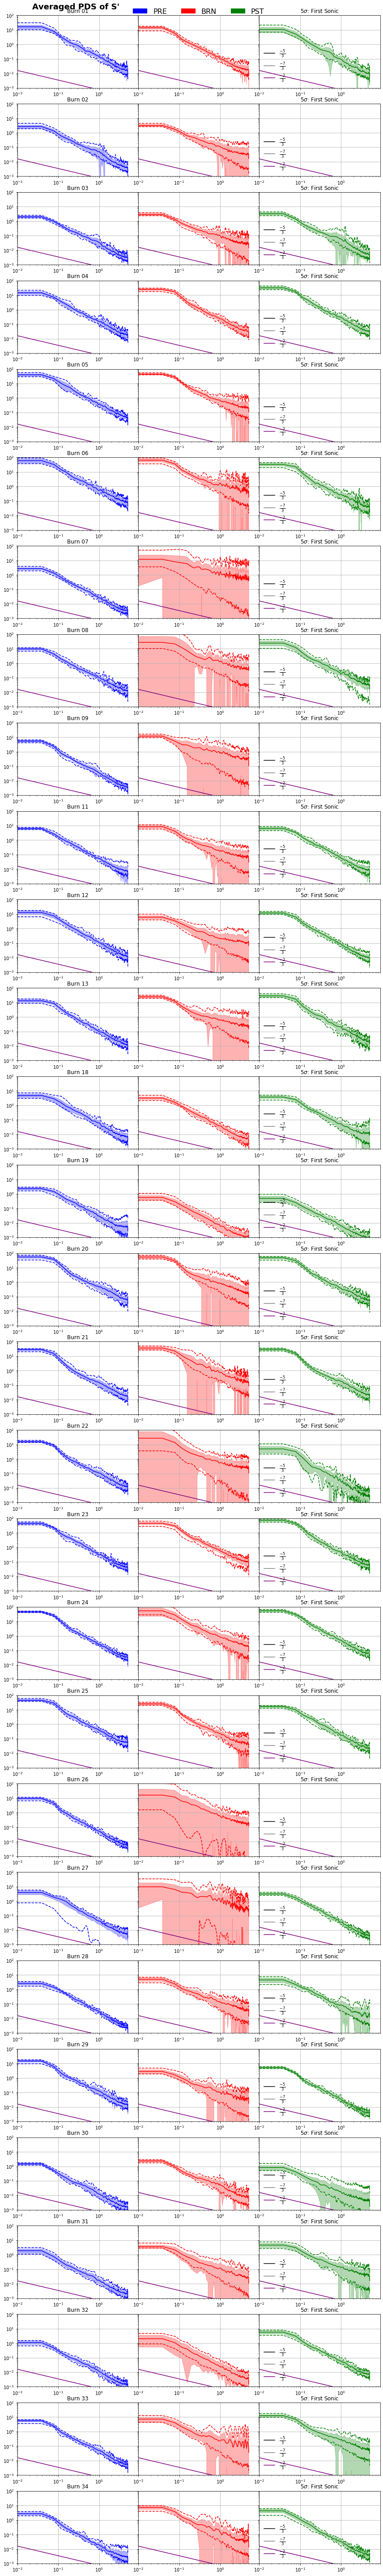

In [77]:
plotting_avs("S",True)
#plotting_avs("S", False)

C:\Users\joeyp\anaconda3\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 28, using nperseg = 28
  .format(nperseg, input_length))
C:\Users\joeyp\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\Users\joeyp\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\Users\joeyp\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\Users\joeyp\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\Users\joeyp\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\Users\joeyp\anaconda3\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 91, using nperseg = 91
  .format(nperseg, input_length))
C:\Users\joeyp\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of em

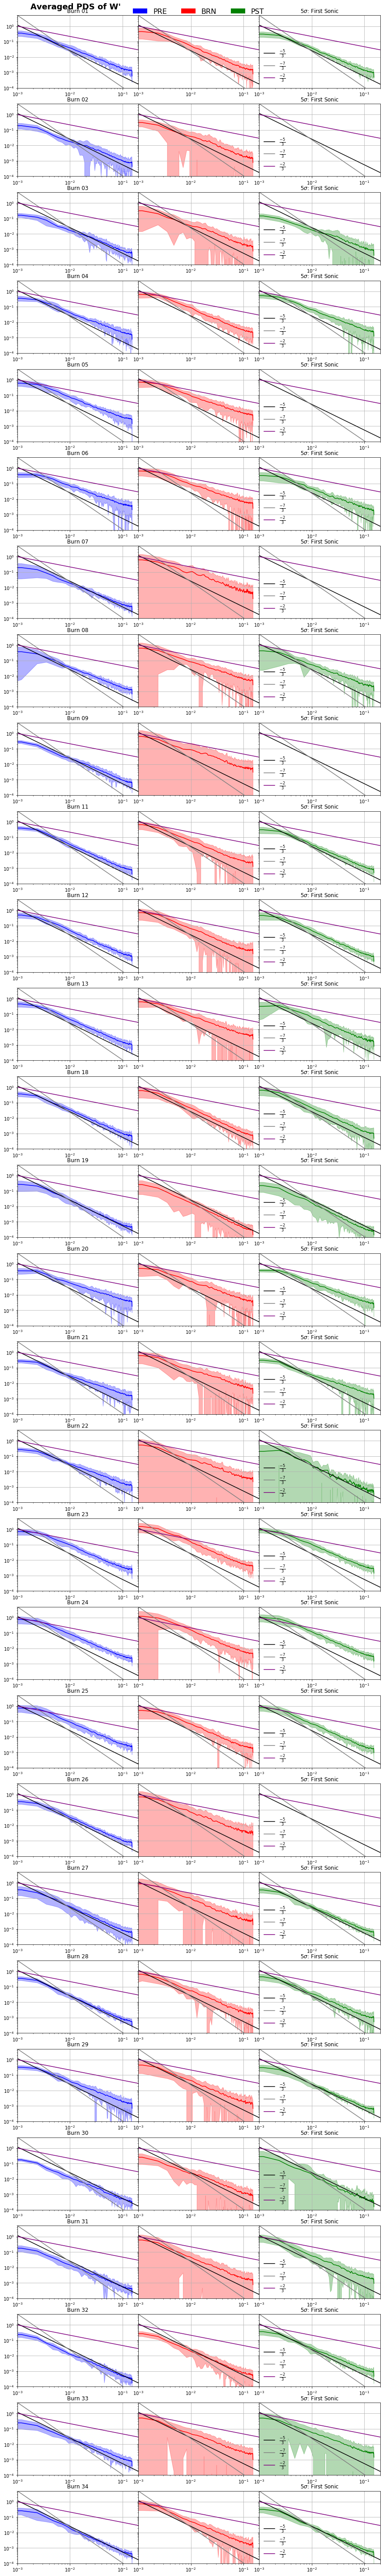

In [29]:
plotting_avs("W",True)
#plotting_avs("W", False)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 28, using nperseg = 28
  .format(nperseg, input_length))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 91, using nperseg = 91
  .format(nperseg, input_length))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of em

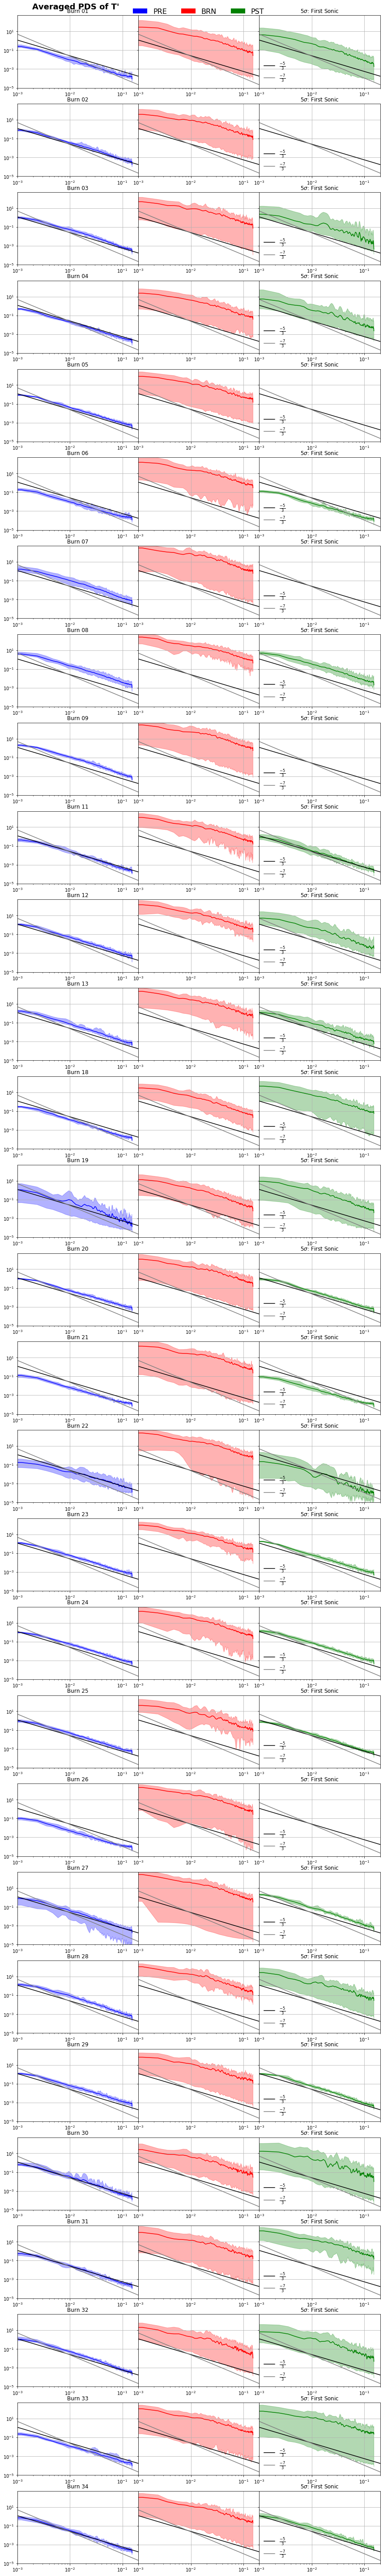

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 29, using nperseg = 29
  .format(nperseg, input_length))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 246, using nperseg = 246
  .format(nperseg, input_length))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 244, using nperseg = 244
  .format(nperseg, input_length))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 234, using nperseg = 234
  .format(nperseg, input_length))
C:\ProgramData\Anaconda3

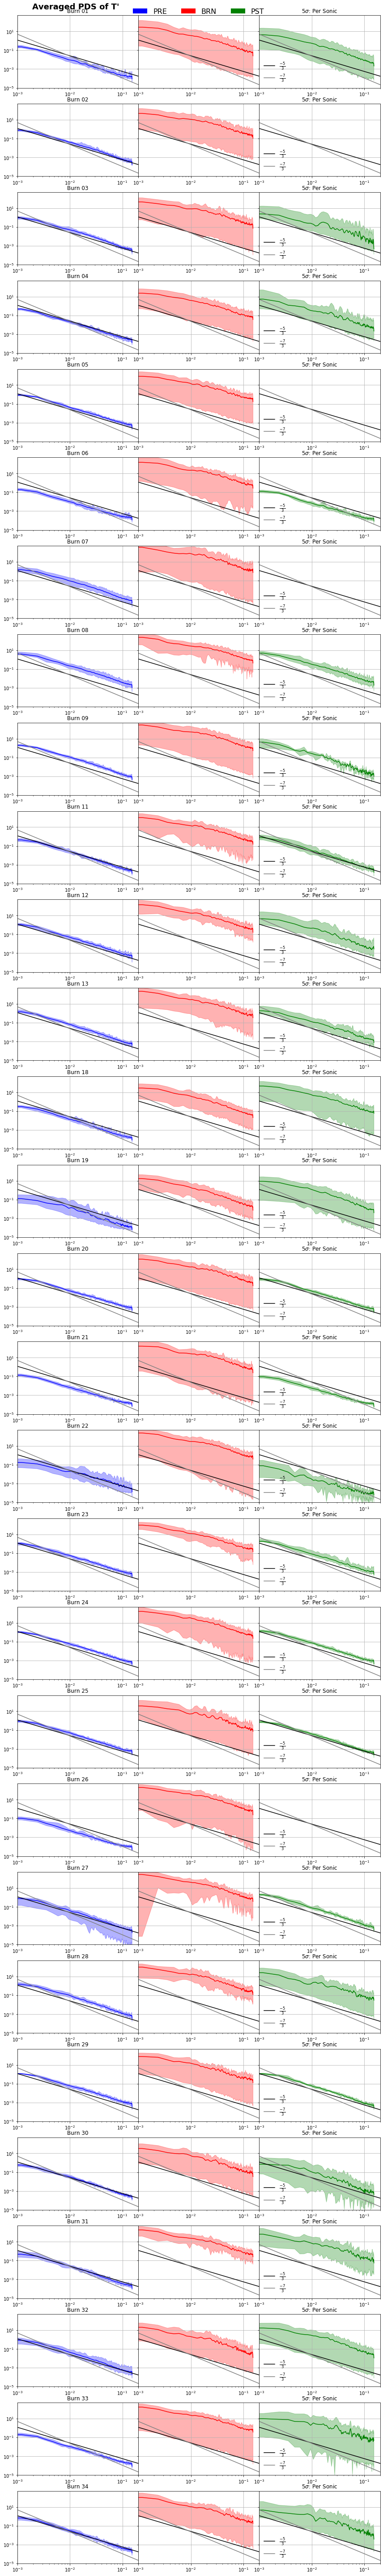

In [119]:
plotting_avs("T",True)
plotting_avs("T", False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


        pre_x  pre_avg_y  pre_min_y  pre_max_y     brn_x  brn_avg_y  \
0    0.000000   0.112907   0.016371   0.154644  0.000000   0.178405   
1    0.001189   0.660039   0.116500   0.889349  0.001189   0.884405   
2    0.002378   0.311023   0.039959   0.387597  0.002378   0.493911   
3    0.003567   0.168988   0.011427   0.255301  0.003567   0.254506   
4    0.004756   0.109053   0.005564   0.165163  0.004756   0.179029   
..        ...        ...        ...        ...       ...        ...   
124  0.147445   0.000654   0.000008   0.000976  0.147445   0.004647   
125  0.148634   0.000646   0.000008   0.000917  0.148634   0.005622   
126  0.149823   0.000698   0.000008   0.001173  0.149823   0.005879   
127  0.151013   0.000669   0.000008   0.001053  0.151013   0.004997   
128  0.152202   0.000340   0.000003   0.000633  0.152202   0.002520   

        brn_min_y  brn_max_y     pst_x  pst_avg_y  pst_min_y  pst_max_y  
0    4.420157e-05   0.322918  0.000000   0.132780   0.107069   0.157708  

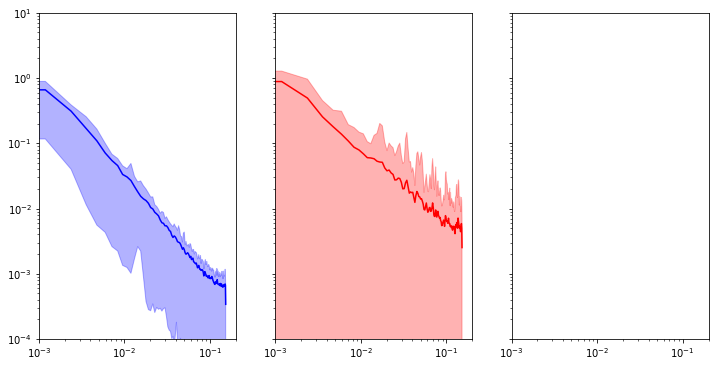

In [36]:
burn = "27"
sigma_fire, variable = True, "S"

path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Full-Timestamp/Burn-" #w10
path_end = "/sonics/"
p = path+burn+ path_end
files = text_finder(p)


file_count, df_list = 0, []
for i in range(16):
    df_list.append(file_to_df(p+files[i]))
    
df_stats = burn_PDS_averages(df_list, sigma_fire, variable,burn)

print(df_stats)
blu_patch = mpatches.Patch(color = "b", label = "PRE", linewidth = .1)
red_patch = mpatches.Patch(color = "r", label = "BRN", linewidth = .1)
grn_patch = mpatches.Patch(color = "g", label = "PST", linewidth = .1)
patches = [blu_patch, red_patch, grn_patch]
    
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(12,6), sharey = True, sharex = True)
ax1 = axs[0]
ax1.loglog(df_stats["pre_x"], df_stats["pre_avg_y"], color = "b")
ax1.fill_between(df_stats["pre_x"], df_stats["pre_min_y"], df_stats["pre_max_y"], color='b', alpha=0.3)
ax1.set_xlim(10**(-3),2*10**-1)
if variable == "T":
    ax1.set_ylim(10**(-5),.5*10**3)
if variable == "W":
    ax1.set_ylim(10**(-4),5*10**(0))
if variable == "S":
    ax1.set_ylim(10**(-4),10**(1))
#plt.show()
ax2 = axs[1]
ax2.loglog(df_stats["brn_x"], df_stats["brn_avg_y"], color = "r")
ax2.fill_between(df_stats["brn_x"], df_stats["brn_min_y"], df_stats["brn_max_y"], color='r', alpha=0.3)
plt.show()
ax3 = axs[2]
ax3.loglog(df_stats["pst_x"], df_stats["pst_avg_y"], color = "g")
ax3.fill_between(df_stats["pst_x"], df_stats["pst_min_y"], df_stats["pst_max_y"], color='g', alpha=0.3)

fig.tight_layout()
leg = fig.legend(handles = patches, ncol = 3, bbox_to_anchor = (.8, 1.07), fontsize = 16)
fig.subplots_adjust(hspace=0.2, wspace=0)#, top=.9)#, left = 0.05, right = .95, bottom = .07)

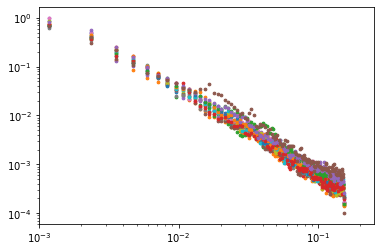

In [48]:
for i in range(16):
    #print(len(pre_all_y[i]))
    plt.scatter(list(pre_all_x[i]),list(pre_all_y[i]), s= 7.5)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlim(.001, .25)